Analysis of network of co-offenders

In [1]:
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [2]:
filename = '/Volumes/My Passport for Mac/IDS/pset2/problem_set_2_data_and_materials/Cooffending.csv'

In [3]:
data = pd.read_csv(filename).to_numpy()

In [4]:
print(data.shape)

(1280459, 13)


In [5]:
crimes = {}
ids = {}

In [6]:
for i in range(data.shape[0]):
    try:
        incidents = ids[data[i][0]]
    except:
        incidents = set()
    incidents.add(data[i][2])
    ids[data[i][0]] = incidents
    
    try:
        associated = crimes[data[i][2]]
    except:
        associated = set()    
    associated.add(data[i][0])
    crimes[data[i][2]] = associated

In [7]:
# total offenders
print(len(ids))

539593


In [8]:
# number of solo offenders

solo = set()
for i in ids:
    solo_offender = True
    for incident in ids[i]:
        if len(crimes[incident]) > 1:
            solo_offender = False
    if solo_offender:
        solo.add(i)
print(len(solo))
        

418434


In [9]:
# number of degree 1 offenders

deg_one = set()
for i in ids:
    neighbors = set()
    for incident in ids[i]:
        for j in crimes[incident]:
            if j != i:
                neighbors.add(j)
    if len(neighbors) == 1:
        deg_one.add(i)
print(len(deg_one))

66102


In [10]:
#don't rerun, removes solo offenders, deg one offenders
for i in solo:
    del ids[i]
for i in deg_one:
    del ids[i]

crimeset = set()
for i in crimes:
    crimeset.add(i)
for c in crimeset:
    none = True
    for i in crimes[c]:
        if i in ids:
            none = False
    if none:
        del crimes[c]

In [11]:
# number of nodes
print(len(ids))

55057


In [12]:
# Remove crimes w/ one person
keys = set()
for i in crimes:
    keys.add(i)
for k in keys:
    if len(crimes[k]) == 1:
        del crimes[k]

In [13]:
# Create edge set
edges = set()
for i in crimes:
    for j in crimes[i]:
        for k in crimes[i]:
            if j < k:
                edges.add((j, k))

In [14]:
# number of edges
print(len(edges))

153278


In [15]:
# prune extra crimes
for i in ids:
    cr = set()
    for c in ids[i]:
        if c in crimes:
            cr.add(c)
    ids[i] = cr

In [16]:
# degree distribution
degs = []
for i in ids:
    cos = set()
    for crime in ids[i]:
        for co in crimes[crime]:
            cos.add(co)
    degs.append(len(cos) - 1)

Text(0.5,1,'Degree Distribution of co-offenders')

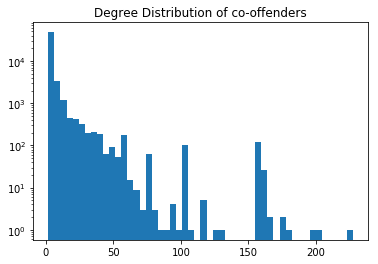

In [17]:
_, _, _ = plt.hist(degs, bins = 50)
plt.yscale("log")
plt.title("Degree Distribution of co-offenders")


In [18]:
print(len(ids))

55057


In [21]:
visit_ids = {}
for i in ids:
    visit_ids[i] = 0

In [22]:
# Find connected components
# Get the neighbors of a specific node
def get_neighbors(i):
    cos = set()
    for crime in ids[i]:
        for co in crimes[crime]:
            if co != i:
                cos.add(co)
    return cos

# Find all connected nodes using a recursive DFS
def recursivelyMark(i, n):
    if visit_ids[i] != 0:
        return
    visit_ids[i] = n
    for j in get_neighbors(i):
        if j in ids:
            recursivelyMark(j, n)

componentsCount = 0
n = 1
for i in ids:
    if not visit_ids[i]:
        componentsCount += 1
        recursivelyMark(i, n)
        n += 1
print(componentsCount)

10963


In [23]:
# Find largest connected components
components = [0 for i in range(10963)]
for i in visit_ids:
    components[visit_ids[i] - 1] += 1
ecomp = list(enumerate(components))
ecomp.sort(key=lambda x:x[1], reverse = True)

In [24]:
print(ecomp[:10])

[(0, 15134), (459, 296), (1187, 87), (89, 65), (2033, 65), (7034, 54), (8362, 50), (461, 49), (1588, 48), (218, 47)]


In [25]:
largest = {}
for i in visit_ids:
    if visit_ids[i] == 1:
        largest[i] = ids[i]

In [26]:
# create degree distribution for largest component
largest_degrees = []
for i in largest:
    count = 0
    for j in get_neighbors(i):
        if j in largest:
            count += 1
    largest_degrees.append(count)

Text(0.5,1,'Degree Distribution of Co-offenders in Largest Connected Component')

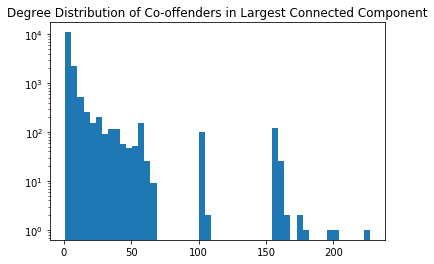

In [27]:
_, _, _ = plt.hist(largest_degrees, bins = 50)
plt.yscale("log")
plt.title("Degree Distribution of Co-offenders in Largest Connected Component")


In [28]:
largest_crime = 0
num_people = 0
for i in crimes:
    if len(crimes[i]) > num_people:
        largest_crime = i
        num_people = len(crimes[i])
print(largest_crime)

27849


In [29]:
# Same code as above, fixed
def get_neighbors(i):
    cos = set()
    for crime in ids[i]:
        for co in crimes[crime]:
            if co != i:
                cos.add(co)
    return cos

def recursivelyMark(i, n):
    if visit_ids[i] != 0:
        return
    visit_ids[i] = n
    for j in get_neighbors(i):
        if j in largest:
            recursivelyMark(j, n)

visit_ids = {}
for i in largest:
    visit_ids[i] = 0
componentsCount = 0
n = 1
for i in largest:
    if visit_ids[i] == 0:
        componentsCount += 1
        recursivelyMark(i, n)
        n += 1
print(componentsCount)

1


In [30]:
# Convert largest component to a graph
id_to_mat = {}
mat_to_id = []
c = 0
for i in largest:
    mat_to_id.append(i)
    id_to_mat[i] = c
    c += 1
for i in range(len(mat_to_id)):
    assert i == id_to_mat[mat_to_id[i]]

dense = np.zeros((len(largest), len(largest)))
for i in largest:
    for j in get_neighbors(i):
        if j in largest:
            x = id_to_mat[i]
            y = id_to_mat[j]
            dense[x, y] = 1
            dense[y, x] = 1


In [31]:
graph = nx.from_numpy_matrix(dense)

In [75]:
print(nx.diameter(graph))

46


In [32]:
print(nx.density(graph))

0.0005745802922644975


In [33]:
print(nx.average_shortest_path_length(graph))

17.555947817287834
